[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


## Highlights

- `tree_` attribute in the fitted decision tree
    - contains some useful information, such as `max_depth`
- `GridSearchCV`
    - implements *cross validation*, needs 
        - a *score to be optimized*
        - *ranges* of the hyperparameters to be optimized, the *parameters grid*
    - sets the values for `best_params_` and `best_estimator_`
- `classification_report`
- `ConfusionMatrixDisplay`



In [ ]:
# import warnings
# warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

### Prepare the environment
Import libraries

Load the dataset `winequality-red-wi.csv`

Set the training set size and the random state

In [93]:
import seaborn as sns
import pandas as pd
train_size = 0.67
random_state = 18 # any positive integer is acceptable, it is necessary for **reproducibility

In [94]:
wine = pd.read_csv('winequality-red.csv', sep=';')
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Read the data into a dataframe and show the size

In [95]:
wine.shape

(1599, 12)

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [96]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

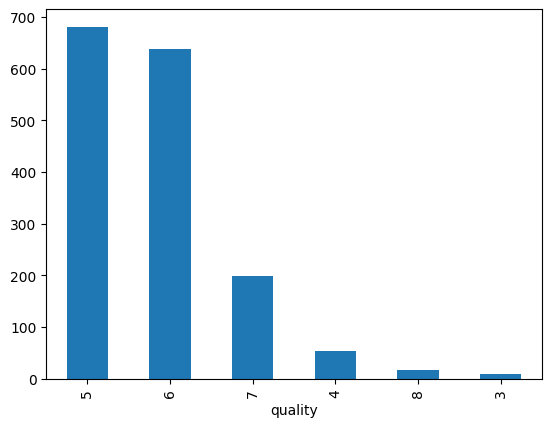

In [97]:
import matplotlib.pyplot as plt
wine.quality.value_counts().plot(kind='bar')

wine.quality.value_counts()

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [98]:
X = wine.drop(columns=['quality'])
y = wine[['quality']]

In [99]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


### Prepare the baseline: holdout method

In [100]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= random_state, train_size = train_size)
print(Xtrain.shape, Xtest.shape) #, ytrain.shape, ytest.shape)

(1071, 11) (528, 11)


In [104]:
ytrain.value_counts()

quality
5          466
6          419
7          128
4           35
8           16
3            7
Name: count, dtype: int64

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [84]:
from sklearn import tree

estimator = tree.DecisionTreeClassifier(random_state=random_state)

estimator = estimator.fit(Xtrain, ytrain)

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [85]:
# Xtest_dt = estimator.predict(Xtest)

from sklearn.metrics import accuracy_score

y_pred_test = estimator.predict(Xtest)

# Compute the accuracy on the test set
accuracy_test = accuracy_score(ytest, y_pred_test)
print(accuracy_test)

fitted_max_depth = estimator.tree_.max_depth
print(fitted_max_depth)

parameter_values = range(1, fitted_max_depth + 1)

0.6306818181818182
22


The accuracy on test set is 63.1%
The maximum depth of the tree fitted on X_train is 22


Prepare the decision tree parameters and the scores 

In [73]:
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]

# Set the different scores that will be optimised
scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification report`
    - display the confusion matrix with `ConfusionMatrixDisplay`


### Optimizing for accuracy ###
Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=18)
Best accuracy Score on Training Data: 0.5723622782446312

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.05      0.06      0.05        18
           5       0.67      0.67      0.67       215
           6       0.62      0.60      0.61       219
           7       0.50      0.51      0.50        71
           8       0.00      0.00      0.00         2

    accuracy                           0.59       528
   macro avg       0.31      0.30      0.31       528
weighted avg       0.60      0.59      0.59       528



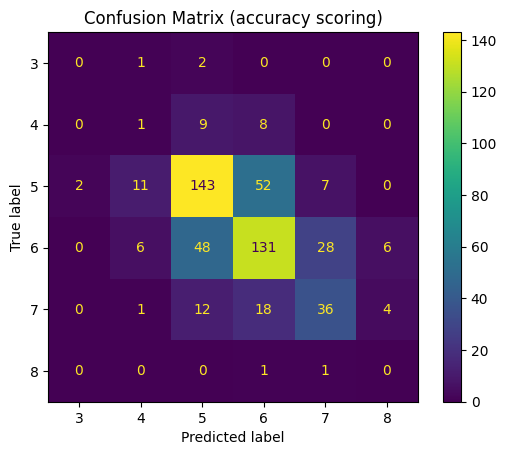


### Optimizing for precision_macro ###


c:\Users\pepij\anaconda3\envs\SIM\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pepij\anaconda3\envs\SIM\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pepij\anaconda3\envs\SIM\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pepi

Best Estimator: DecisionTreeClassifier(class_weight='balanced', max_depth=18, random_state=18)
Best precision_macro Score on Training Data: 0.3279773094025619

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.11      0.11      0.11        18
           5       0.64      0.72      0.68       215
           6       0.59      0.54      0.56       219
           7       0.44      0.38      0.41        71
           8       0.00      0.00      0.00         2

    accuracy                           0.57       528
   macro avg       0.30      0.29      0.29       528
weighted avg       0.57      0.57      0.57       528



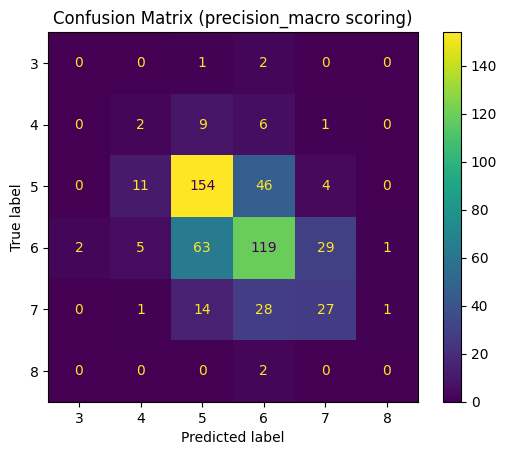


### Optimizing for recall_macro ###
Best Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, random_state=18)
Best recall_macro Score on Training Data: 0.3361826345946926

Classification Report:
              precision    recall  f1-score   support

           3       0.11      0.33      0.17         3
           4       0.06      0.28      0.10        18
           5       0.58      0.52      0.55       215
           6       0.50      0.28      0.36       219
           7       0.38      0.44      0.41        71
           8       0.02      0.50      0.04         2

    accuracy                           0.40       528
   macro avg       0.28      0.39      0.27       528
weighted avg       0.50      0.40      0.43       528



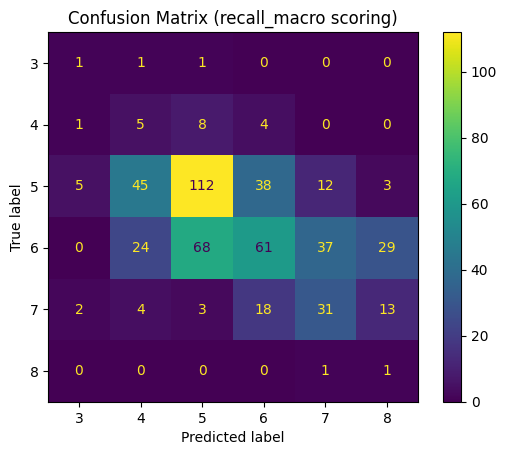


### Optimizing for f1_macro ###
Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=18)
Best f1_macro Score on Training Data: 0.3153144168678023

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.05      0.06      0.05        18
           5       0.67      0.67      0.67       215
           6       0.62      0.60      0.61       219
           7       0.51      0.52      0.51        71
           8       0.00      0.00      0.00         2

    accuracy                           0.59       528
   macro avg       0.31      0.31      0.31       528
weighted avg       0.60      0.59      0.60       528



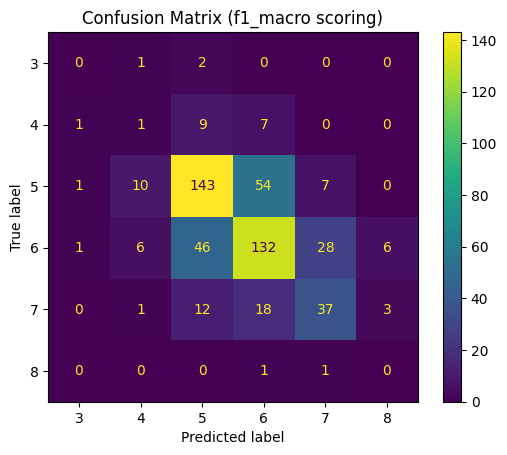

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Loop over each score function
for score in scores:
    print(f"\n### Optimizing for {score} ###")
    estimator = tree.DecisionTreeClassifier(random_state=random_state)
    # Set up GridSearchCV with the given parameters and scoring function
    grid_search = GridSearchCV(estimator, tuned_param_dt, scoring=score, cv=3)
    grid_search.fit(Xtrain, ytrain)

    # Get the best estimator and the corresponding score
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_

    # Print the best estimator and the best score
    print("Best Estimator:", best_estimator)
    print(f"Best {score} Score on Training Data: {best_score}")

    # Predict the target for the test set
    y_pred_test = best_estimator.predict(Xtest)

    # Print the classification report
    print("\nClassification Report:")
    print(classification_report(ytest, y_pred_test))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_estimator(best_estimator, Xtest, ytest)
    plt.title(f"Confusion Matrix ({score} scoring)")
    plt.show()


# Tuning hyper-parameters for accuracy
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 15}
Best score 59.851%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.07      0.05      0.06        21
           5       0.66      0.72      0.69       222
           6       0.60      0.55      0.57       216
           7       0.47      0.46      0.46        59
           8       0.22      0.29      0.25         7

    accuracy                           0.58       528
   macro avg       0.34      0.34      0.34       528
weighted avg       0.58      0.58      0.58       528

# Tuning hyper-parameters for precision_macro
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
Best score 39.211%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.12      0.05      0.07        21
           5       0.70      0.74      0.72   

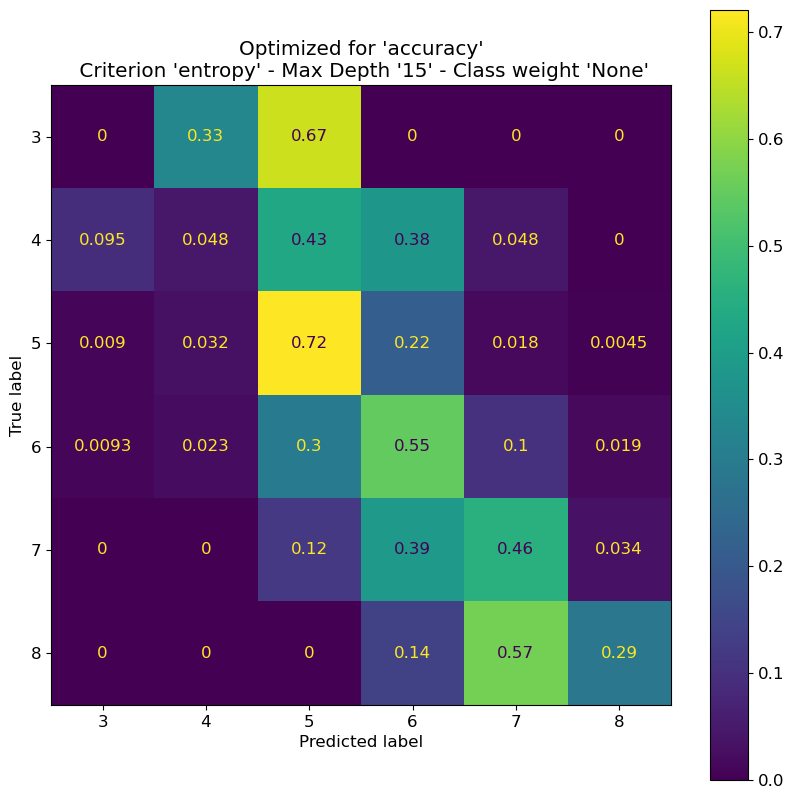

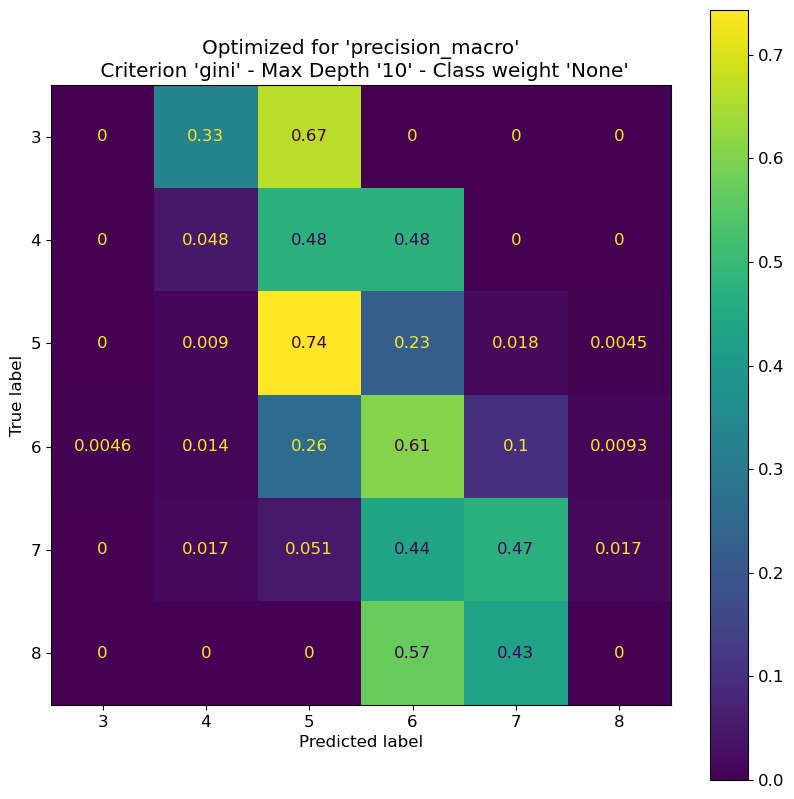

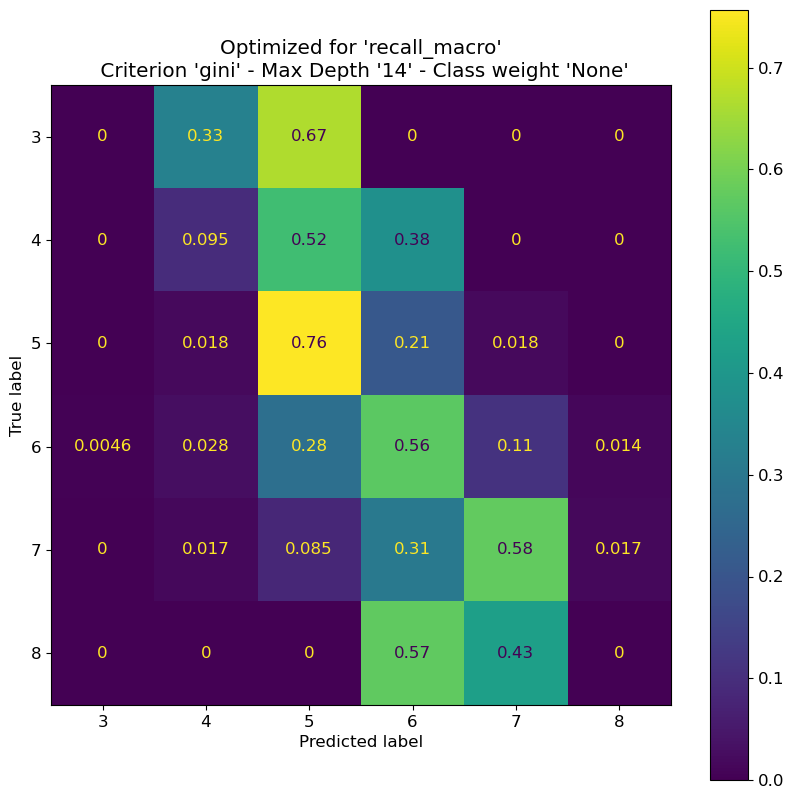

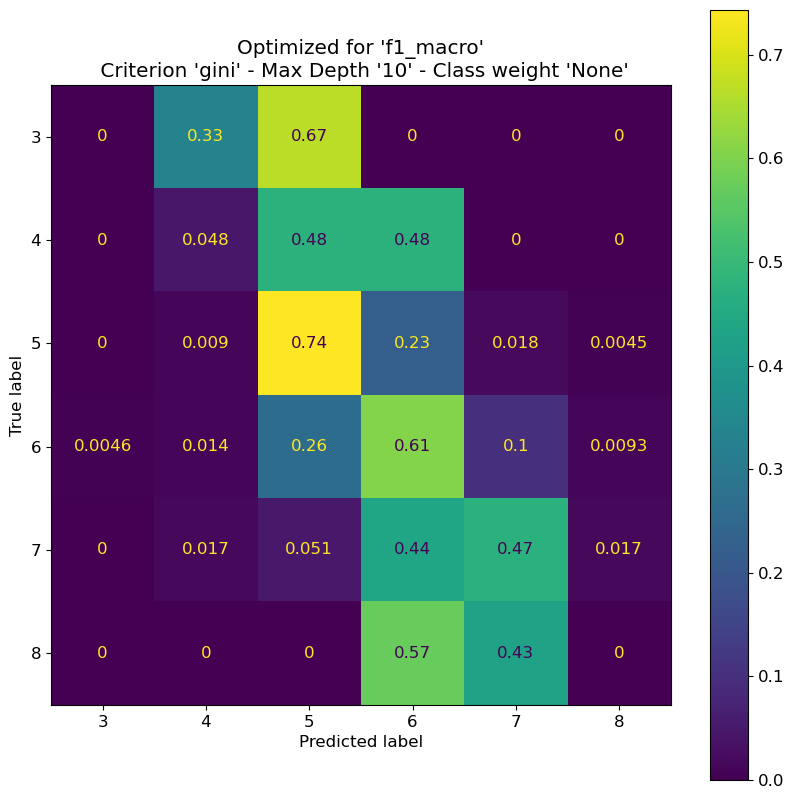

In [56]:
clf.best_params_

NameError: name 'clf' is not defined

In [13]:
clf.best_params_

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10}